Project Title: Understanding What Makes You Happy — A Machine Learning driven Approach
      Team Information
Names: Avisweta De (MSD25001) and Moumita Paul (MSA25014)


Objective

The aim of this project is to identify key factors that influence an individual's happiness level using machine learning techniques.The dataset contains survey-based responses on lifestyle, habits, emotional well-being, and social interactions.We have circulated the google form and collected the necessary data. 
Dataset Description:
Dataset contain 14 coloumns and 262 rows.

Approach & Methodology
1. Data Collection & Preprocessing

Cleaned inconsistent values

Encoded categorical variables

Standardized numerical features

Performed initial Exploratory Data Analysis (EDA)

Data Visualization: Barplot, violin plot, Pairplot, Histograms, hexbin plot, Boxplot, scatter plot along with the trendline shown and Correlation Heatmap has been done for the purpose of data analysis.

2. Feature Engineering (Clustering)

Created new features using the original features.

3. Model Development

Multiple models has been tried but it has been found that the dataset mainly gives best accuracy for Random Forest Classifier model.
Random Forest Model

4. Model Evaluation

Accuracy score

Classification report (Precision, Recall, F1-score)

5. Explainability Using SHAP

To understand why the model makes certain predictions:

SHAP summary plot used to identify most influential features

6. Clustering: The dataset ha sbeen divided into three clusters and data analysis performed among those clusters.

 Challenges Faced
 
1.Limited Dataset Size → Model Underfitting
One of the major challenges was that the dataset contained very few samples, which led to underfitting.
With limited data, the model struggled to learn meaningful patterns, resulting in unstable predictions and lower evaluation scores.

2.Many survey responses were recorded as object or categorical data types.
Converting them into machine-readable numeric formats (OneHotEncoding, Label Encoding) involved challenges such as:
handling high-cardinality features,
ensuring encoding consistency between train and test sets,
preventing data leakage.

3.Model Accuracy was initially low with certain models but after trying with different models and performing hyperparameter tuning model accuracy has risen up to 95.76 %.

Future Enhancements

This project can be improved by:

1. Increasing Dataset Size

More samples will help improve model accuracy and generalization.

2. Adding features to the dataset that can influence happiness.

3. Building a Streamlit App

An interactive UI where users can:

Answer survey questions

Get predicted happiness level

See SHAP explanation

4. Adding NLP Analysis

If free-text responses are included, sentiment analysis can be used.

In [26]:
import pandas as pd
import numpy as np
import re

#Dataset read
df = pd.read_csv("project data.csv")

# Strip extra spaces from column names
df.columns = df.columns.str.strip()

print("Original columns:")
print(df.columns.tolist())

# 2. Rename columns by index to short names
df = df.rename(columns={
    df.columns[0]: "Age",
    df.columns[1]: "Gender",
    df.columns[2]: "Annual_Income",
    df.columns[3]: "Current_Residence",
    df.columns[4]: "Student",
    df.columns[5]: "Stay_with_family",
    df.columns[6]: "Study_time",
    df.columns[7]: "Hobbies_time",
    df.columns[8]: "Personal_needs",
    df.columns[9]: "Family_time",
    df.columns[10]: "Partner_time",
    df.columns[11]: "Friends_time",
    df.columns[12]: "Health_affect_happiness",
    df.columns[13]: "Overall_Happiness"
})

print("\nRenamed columns:")
print(df.columns.tolist())




Original columns:
['What is your age?', 'What is your gender?', 'What is your annual family income in INR?', 'What is your place of current residence?', 'What is your current status?', 'Do you stay with / away from any of your family members currently?', 'How much time do you spend working/studying daily on an average?', 'How much time do you spend on hobbies on a daily basis?', 'How much time do you spend on personal needs?', 'How many hours a day do you spend with your family and relatives? (parents, pets, etc.)', 'How much time do you spend with your partner?', 'How many hours a day do you spend with friends?', 'On a scale of 0-5, how much do your prevailing health issues affect your happiness?', 'On a scale of 0-5, how would you rate your overall happiness?']

Renamed columns:
['Age', 'Gender', 'Annual_Income', 'Current_Residence', 'Student', 'Stay_with_family', 'Study_time', 'Hobbies_time', 'Personal_needs', 'Family_time', 'Partner_time', 'Friends_time', 'Health_affect_happiness',

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler

# ---------------------------------------------------------
# 1. Clean object/string columns (strip, remove \n, \r)
# ---------------------------------------------------------
obj_cols = df.select_dtypes(include="object").columns
for col in obj_cols:
    df[col] = (
        df[col].astype(str)
        .str.strip()
        .str.replace("\n", "", regex=False)
        .str.replace("\r", "", regex=False)
    )

print("\nObject columns:", obj_cols.tolist())

# ---------------------------------------------------------
# 2. Convert time-range columns → numeric midpoints
# ---------------------------------------------------------
time_cols = [
    "Study_time", "Hobbies_time", "Personal_needs",
    "Family_time", "Partner_time", "Friends_time"
]

def convert_to_midpoint(x):
    if pd.isna(x):
        return np.nan

    x = str(x).lower()
    for word in ["hours", "hour", "hrs", "hr"]:
        x = x.replace(word, "")
    x = x.strip()

    if x == "":
        return np.nan

    # values like "12+"
    if "+" in x:
        try:
            return float(x.replace("+", "").strip())
        except ValueError:
            return np.nan

    # ranges like "3-5.5"
    if "-" in x:
        low, high = x.split("-")[0].strip(), x.split("-")[1].strip()
        try:
            return (float(low) + float(high)) / 2
        except:
            return np.nan

    # numeric single value
    try:
        return float(x)
    except:
        return np.nan

df[time_cols] = df[time_cols].applymap(convert_to_midpoint)

print("\nTime columns converted (head):")
print(df[time_cols].head())

# ---------------------------------------------------------
# 3. Clean + Convert Annual Income column
# ---------------------------------------------------------
def convert_income(x):
    x = str(x).strip().lower()

    # less than 2
    if "less" in x and "2" in x:
        return 1.0  

    # more than 12
    if "more" in x and "12" in x:
        return 15.0  

    # ranges: "2 Lakhs - 6 Lakhs"
    nums = re.findall(r"\d+", x)
    if len(nums) == 2:
        low, high = map(float, nums)
        return (low + high) / 2.0

    # single value
    if len(nums) == 1:
        return float(nums[0])

    return np.nan

df["Annual_Income"] = df["Annual_Income"].apply(convert_income)
print("\nAnnual_Income converted (head):")
print(df["Annual_Income"].head())

# ---------------------------------------------------------
# 4. Convert numeric columns to numeric dtype
# ---------------------------------------------------------
numeric_cols = [
    "Age", "Annual_Income",
    "Study_time", "Hobbies_time", "Personal_needs",
    "Family_time", "Partner_time", "Friends_time",
    "Health_affect_happiness", "Overall_Happiness"
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

print("\nNumeric dtype check:")
print(df[numeric_cols].dtypes)

# ---------------------------------------------------------
# 5. Convert selected columns to categorical
# ---------------------------------------------------------
categorical_cols = ["Gender", "Current_Residence", "Student", "Stay_with_family"]
df[categorical_cols] = df[categorical_cols].astype("category")

print("\nPost-categorization dtypes:")
print(df.dtypes)

# ---------------------------------------------------------
# 6. One-hot encode categorical columns
# ---------------------------------------------------------
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# ---------------------------------------------------------
# 7. Normalize numeric columns (Min-Max)
# ---------------------------------------------------------
scaler = MinMaxScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

print("\nFinal encoded + normalized dataset:")
print(df_encoded.head())

print("\nFinal shape:", df_encoded.shape)



Object columns: ['Gender', 'Annual_Income', 'Current_Residence', 'Student', 'Stay_with_family', 'Study_time', 'Hobbies_time', 'Personal_needs', 'Family_time', 'Partner_time', 'Friends_time']

Time columns converted (head):
   Study_time  Hobbies_time  Personal_needs  Family_time  Partner_time  \
0        4.25          7.25           10.25         0.25          4.25   
1       10.25          0.25           10.25         1.75          0.25   
2        4.25          0.25           10.25         1.75          0.25   
3        7.25          0.25           10.25         1.75          4.25   
4        4.25          1.75           10.25         4.25          0.25   

   Friends_time  
0          1.75  
1          4.25  
2          1.75  
3          7.25  
4          1.75  

Annual_Income converted (head):
0    15.0
1     4.0
2     1.0
3     4.0
4    15.0
Name: Annual_Income, dtype: float64

Numeric dtype check:
Age                          int64
Annual_Income              float64
Study_time  

C:\Users\avisw\AppData\Local\Temp\ipykernel_17488\2526443979.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[time_cols] = df[time_cols].applymap(convert_to_midpoint)


In [28]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Age                      262 non-null    int64   
 1   Gender                   262 non-null    category
 2   Annual_Income            262 non-null    float64 
 3   Current_Residence        262 non-null    category
 4   Student                  262 non-null    category
 5   Stay_with_family         262 non-null    category
 6   Study_time               262 non-null    float64 
 7   Hobbies_time             262 non-null    float64 
 8   Personal_needs           262 non-null    float64 
 9   Family_time              262 non-null    float64 
 10  Partner_time             262 non-null    float64 
 11  Friends_time             262 non-null    float64 
 12  Health_affect_happiness  262 non-null    int64   
 13  Overall_Happiness        262 non-null    int64   
dtypes: categor

In [29]:
df.shape

(262, 14)

In [30]:
pip install matplotlib seaborn


You should consider upgrading via the 'c:\Users\avisw\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Boxplot (Box-and-Whisker Plot):
A boxplot is a graphical method used to summarize the distribution of a dataset by displaying its median, quartiles, spread (interquartile range), and potential outliers.

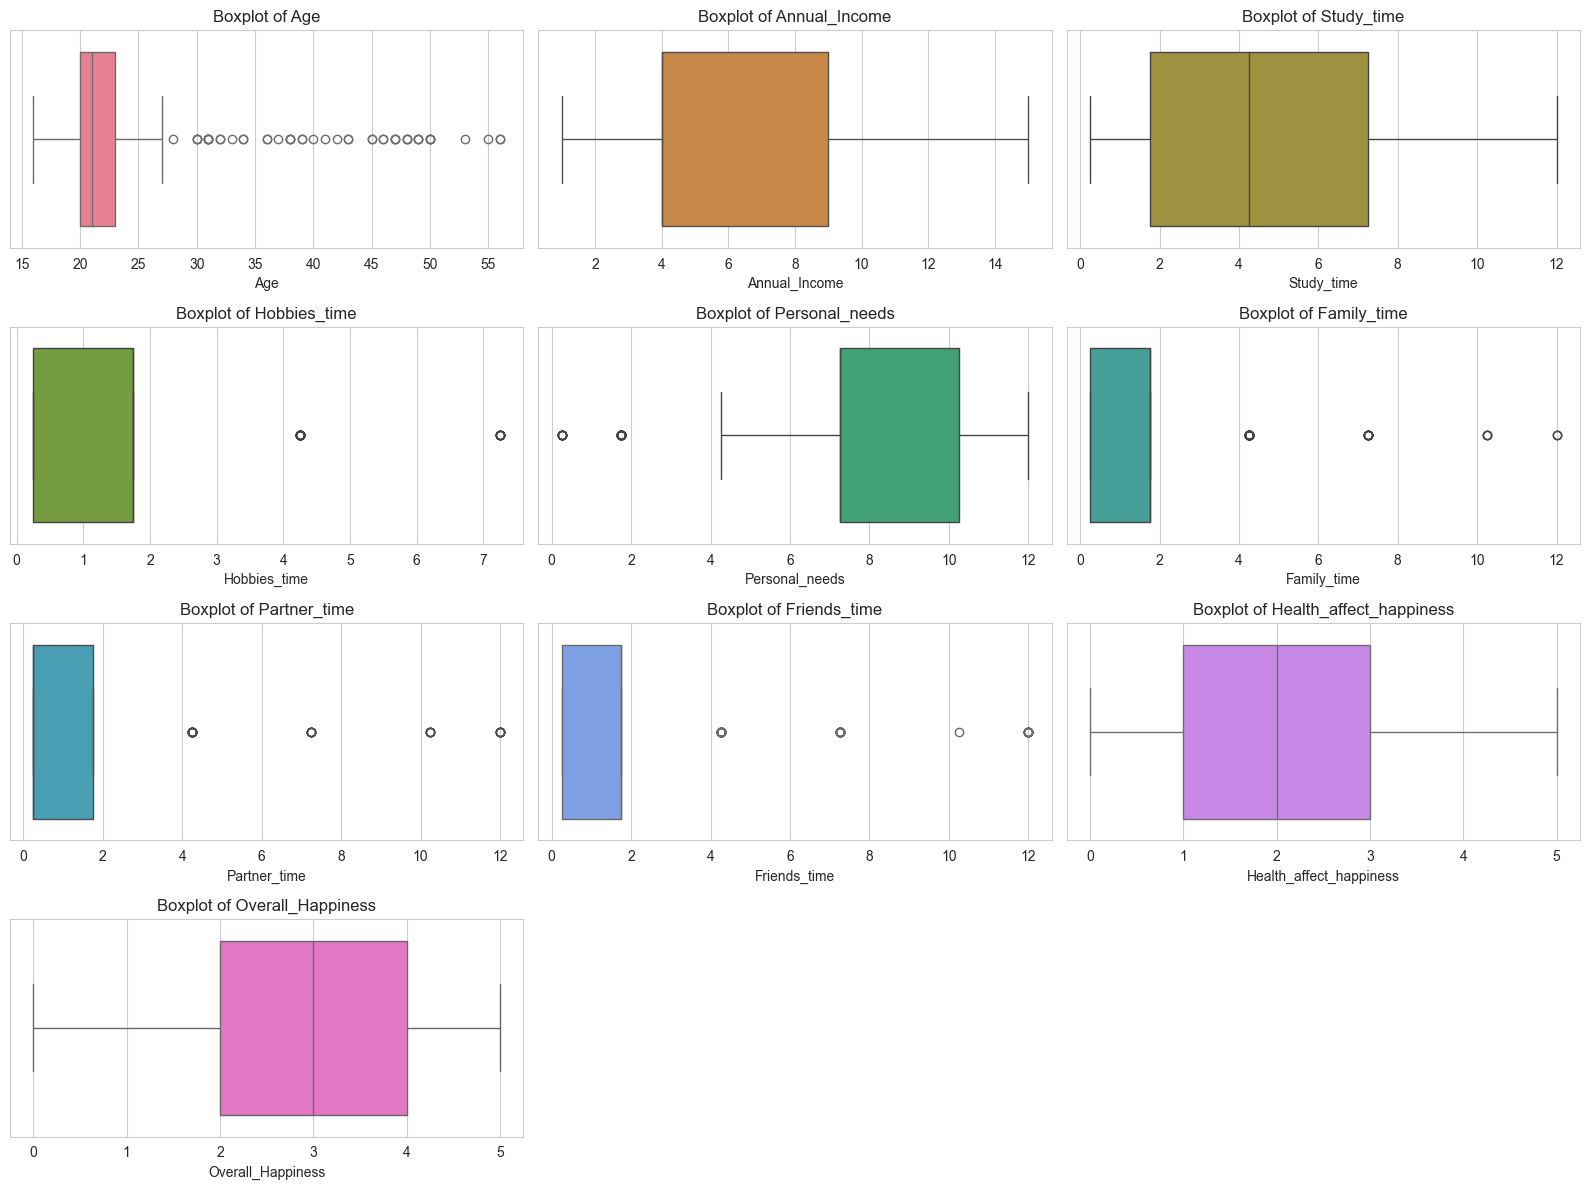

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a color palette with enough distinct colors
colors = sns.color_palette("husl", len(numeric_cols))

plt.figure(figsize=(16, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[col], color=colors[i-1])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


Histogram:
A histogram is a graphical representation of the distribution of a continuous numerical variable, where data are grouped into class intervals and the height of each bar shows the frequency of observations in that interval.

Bar Graph:
A bar graph is a graphical representation of categorical data, where separate bars represent different categories and the height of each bar shows the frequency or value of each category.

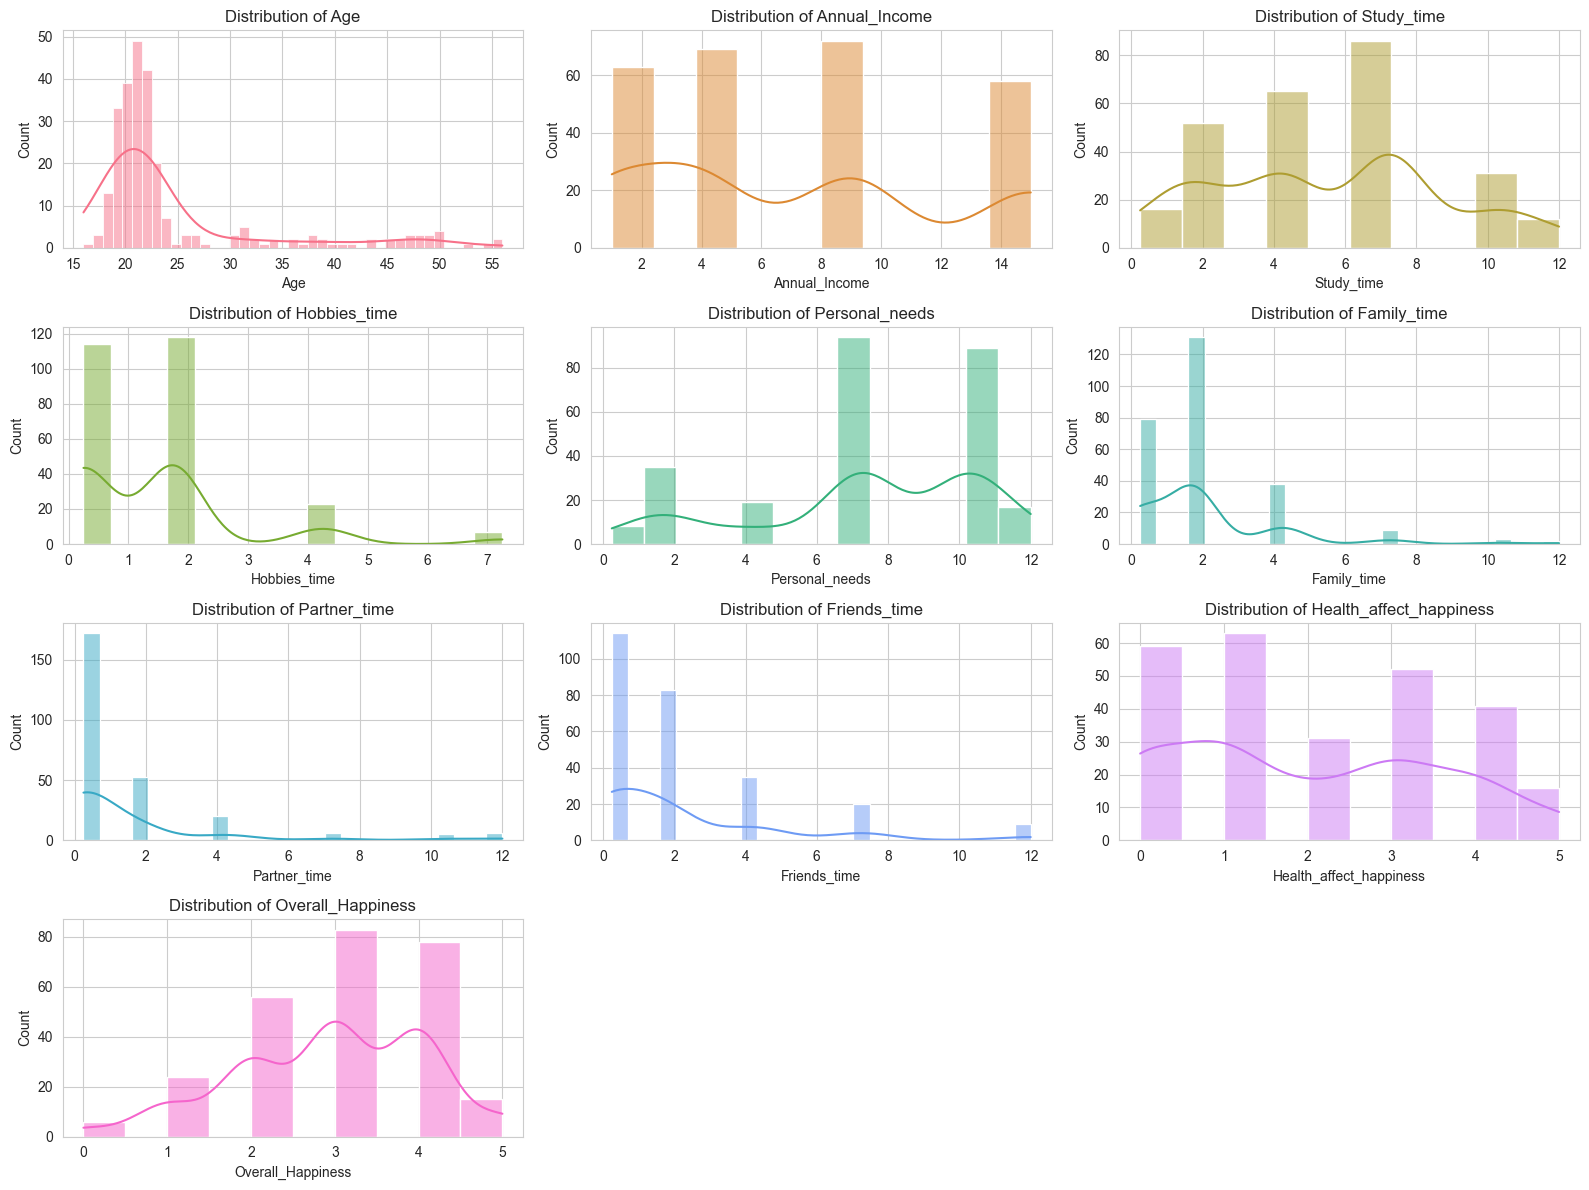

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# choose a color palette with enough colors
colors = sns.color_palette("husl", len(numeric_cols))

plt.figure(figsize=(16, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[col], kde=True, color=colors[i-1])
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


Violin Plot:
A violin plot is a graphical method used to visualize the distribution of a numerical variable by combining a box plot with a kernel density plot, showing the data’s spread, central tendency, and probability density across different values.

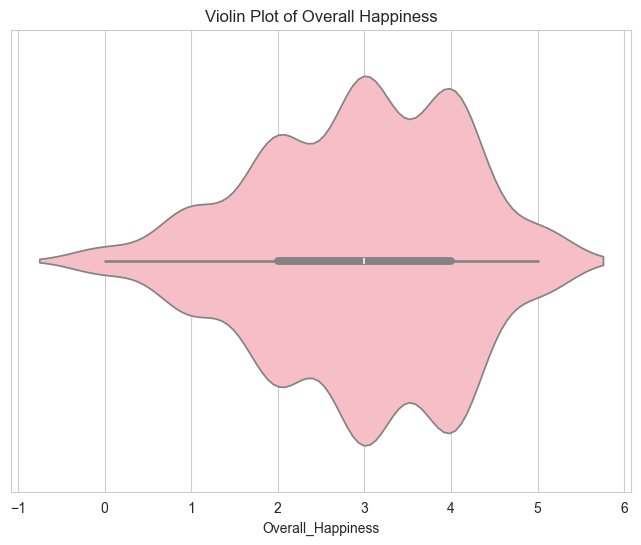

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.violinplot(x=df["Overall_Happiness"], color="#FFB6C1")  # light pink color
plt.title("Violin Plot of Overall Happiness")
plt.show()


This is a grouped bar graph that shows the distribution of overall happiness levels across different types of current residence (Rural, Suburbs, Urban). Each group of bars represents a residence type, and the height of each bar indicates the count of individuals at a specific happiness level, allowing comparison of happiness distributions across residential categories.

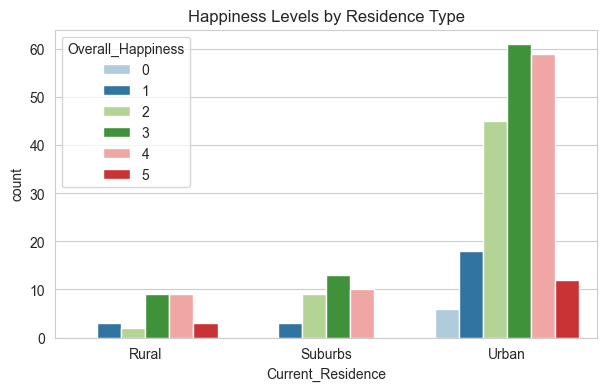

In [34]:
plt.figure(figsize=(7,4))
sns.countplot(data=df, x="Current_Residence", hue="Overall_Happiness", palette="Paired")
plt.title("Happiness Levels by Residence Type")
plt.show()


This is a bar graph that represents the distribution of overall happiness levels in the dataset. Each bar corresponds to a happiness score, and the height of the bar indicates the number of respondents falling into that score, helping to visualize the frequency distribution of happiness levels.

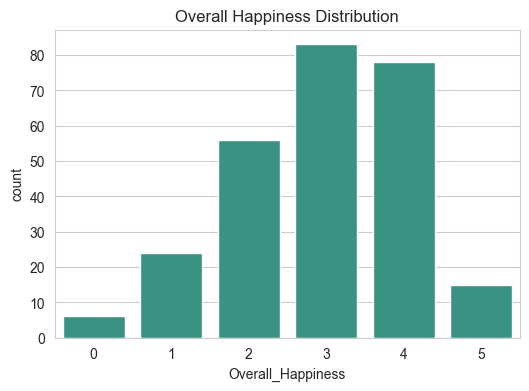

In [35]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df["Overall_Happiness"], color="#2CA08C")   # nice blue
plt.title("Overall Happiness Distribution")
plt.show()



This is a hexbin plot that visualizes the relationship between family time and partner time by grouping data points into hexagonal bins. The color intensity (shown on a logarithmic scale) represents the density or count of observations within each bin, making it useful for identifying concentration patterns in large or overlapping datasets.

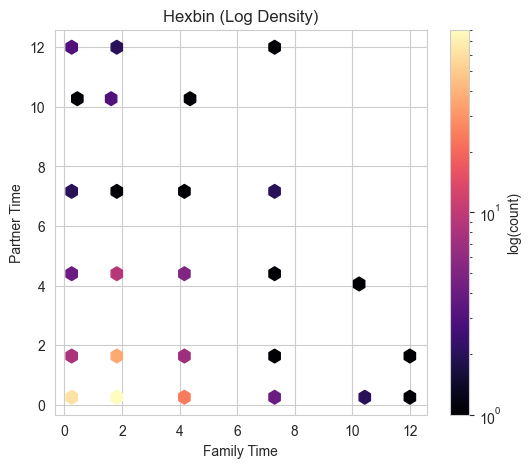

In [36]:
plt.figure(figsize=(6,5))
plt.hexbin(df['Family_time'], df['Partner_time'], gridsize=30, cmap='magma', bins='log')
plt.colorbar(label='log(count)')
plt.xlabel("Family Time")
plt.ylabel("Partner Time")
plt.title("Hexbin (Log Density)")
plt.show()




This is a hexbin plot illustrating the relationship between study time and hobbies time. The data points are aggregated into hexagonal bins, and the color intensity (on a logarithmic scale) represents the density of observations, making it effective for identifying patterns and concentration of time allocation between studying and leisure activities.

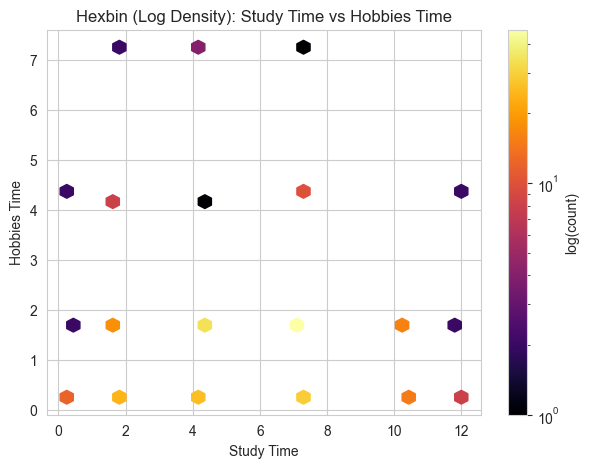

In [37]:
plt.figure(figsize=(7,5))
plt.hexbin(
    df['Study_time'],
    df['Hobbies_time'],
    gridsize=30,
    cmap='inferno',
    bins='log'
)
plt.colorbar(label='log(count)')
plt.xlabel("Study Time")
plt.ylabel("Hobbies Time")
plt.title("Hexbin (Log Density): Study Time vs Hobbies Time")
plt.show()


Correlation Heatmap:
A correlation heatmap is a graphical representation of the correlation matrix, where colors indicate the strength and direction of relationships between pairs of variables, helping to quickly identify positive, negative, and weak correlations in the data.

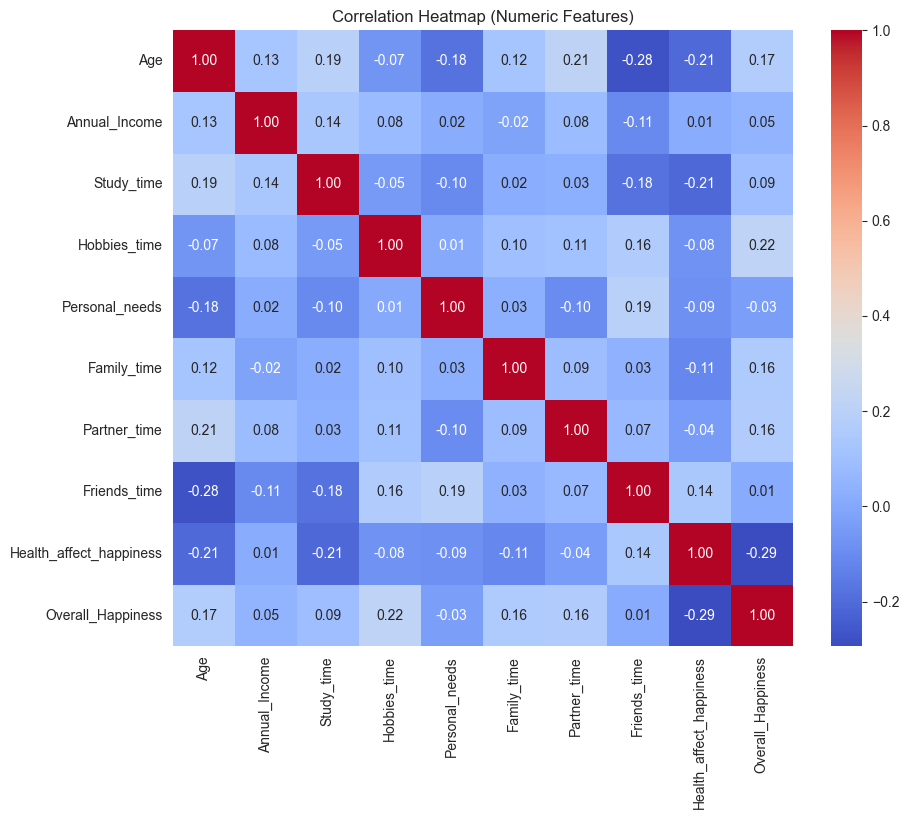

In [38]:
plt.figure(figsize=(10, 8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

These are scatter plots with fitted regression lines used to examine the relationship between overall happiness and various explanatory variables (such as age, income, study time, family time, hobbies time, etc.). Each point represents an individual observation, while the regression line indicates the overall trend and direction of association between the variables, helping to identify positive, negative, or weak relationships.

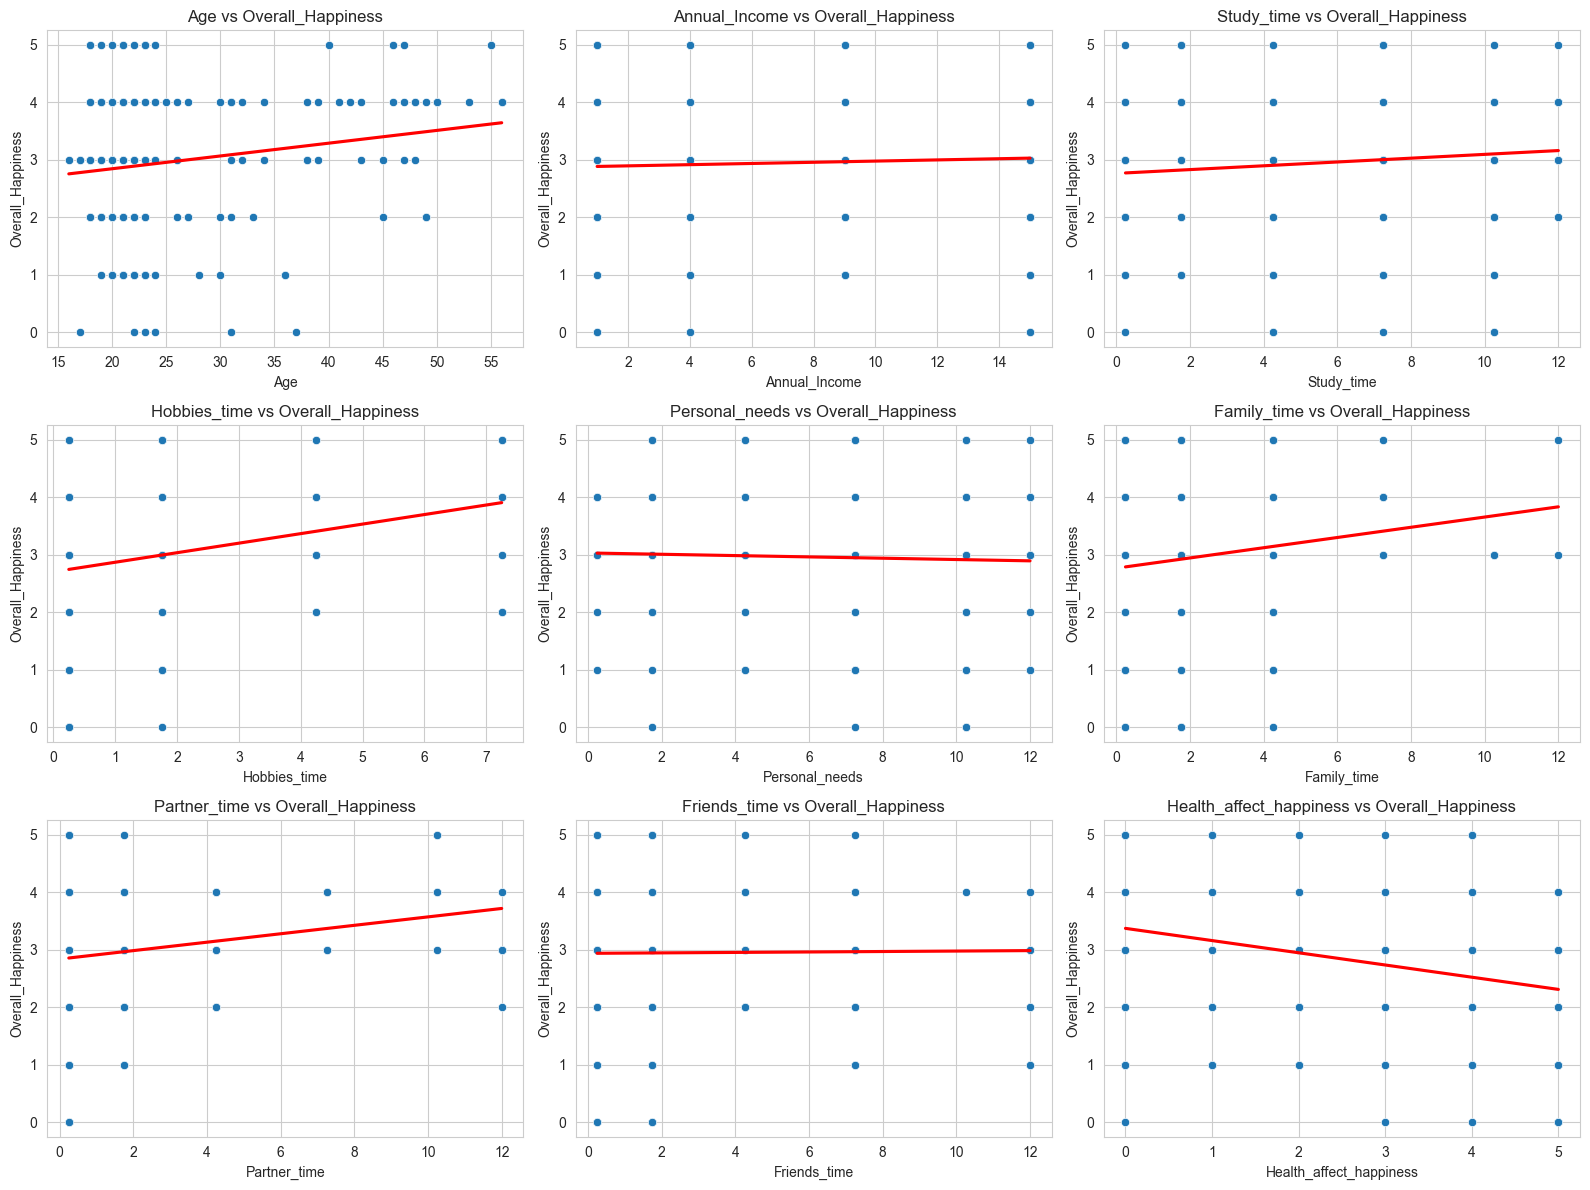

In [39]:
sns.set_style("whitegrid")   # light background with grid

target = "Overall_Happiness"

plt.figure(figsize=(16, 12))
plot_idx = 1
for col in numeric_cols:
    if col == target:
        continue
    plt.subplot(3, 3, plot_idx)
    sns.scatterplot(x=df[col], y=df[target])
    sns.regplot(x=df[col], y=df[target], scatter=False, ci=None, color="red")
    plt.title(f"{col} vs {target}")
    plot_idx += 1

plt.tight_layout()
plt.show()


Pair Plot:
A pair plot is a multivariate visualization that displays pairwise relationships between numerical variables using scatter plots, along with the distribution of each variable on the diagonal, helping to identify correlations, patterns, and outliers in the data.

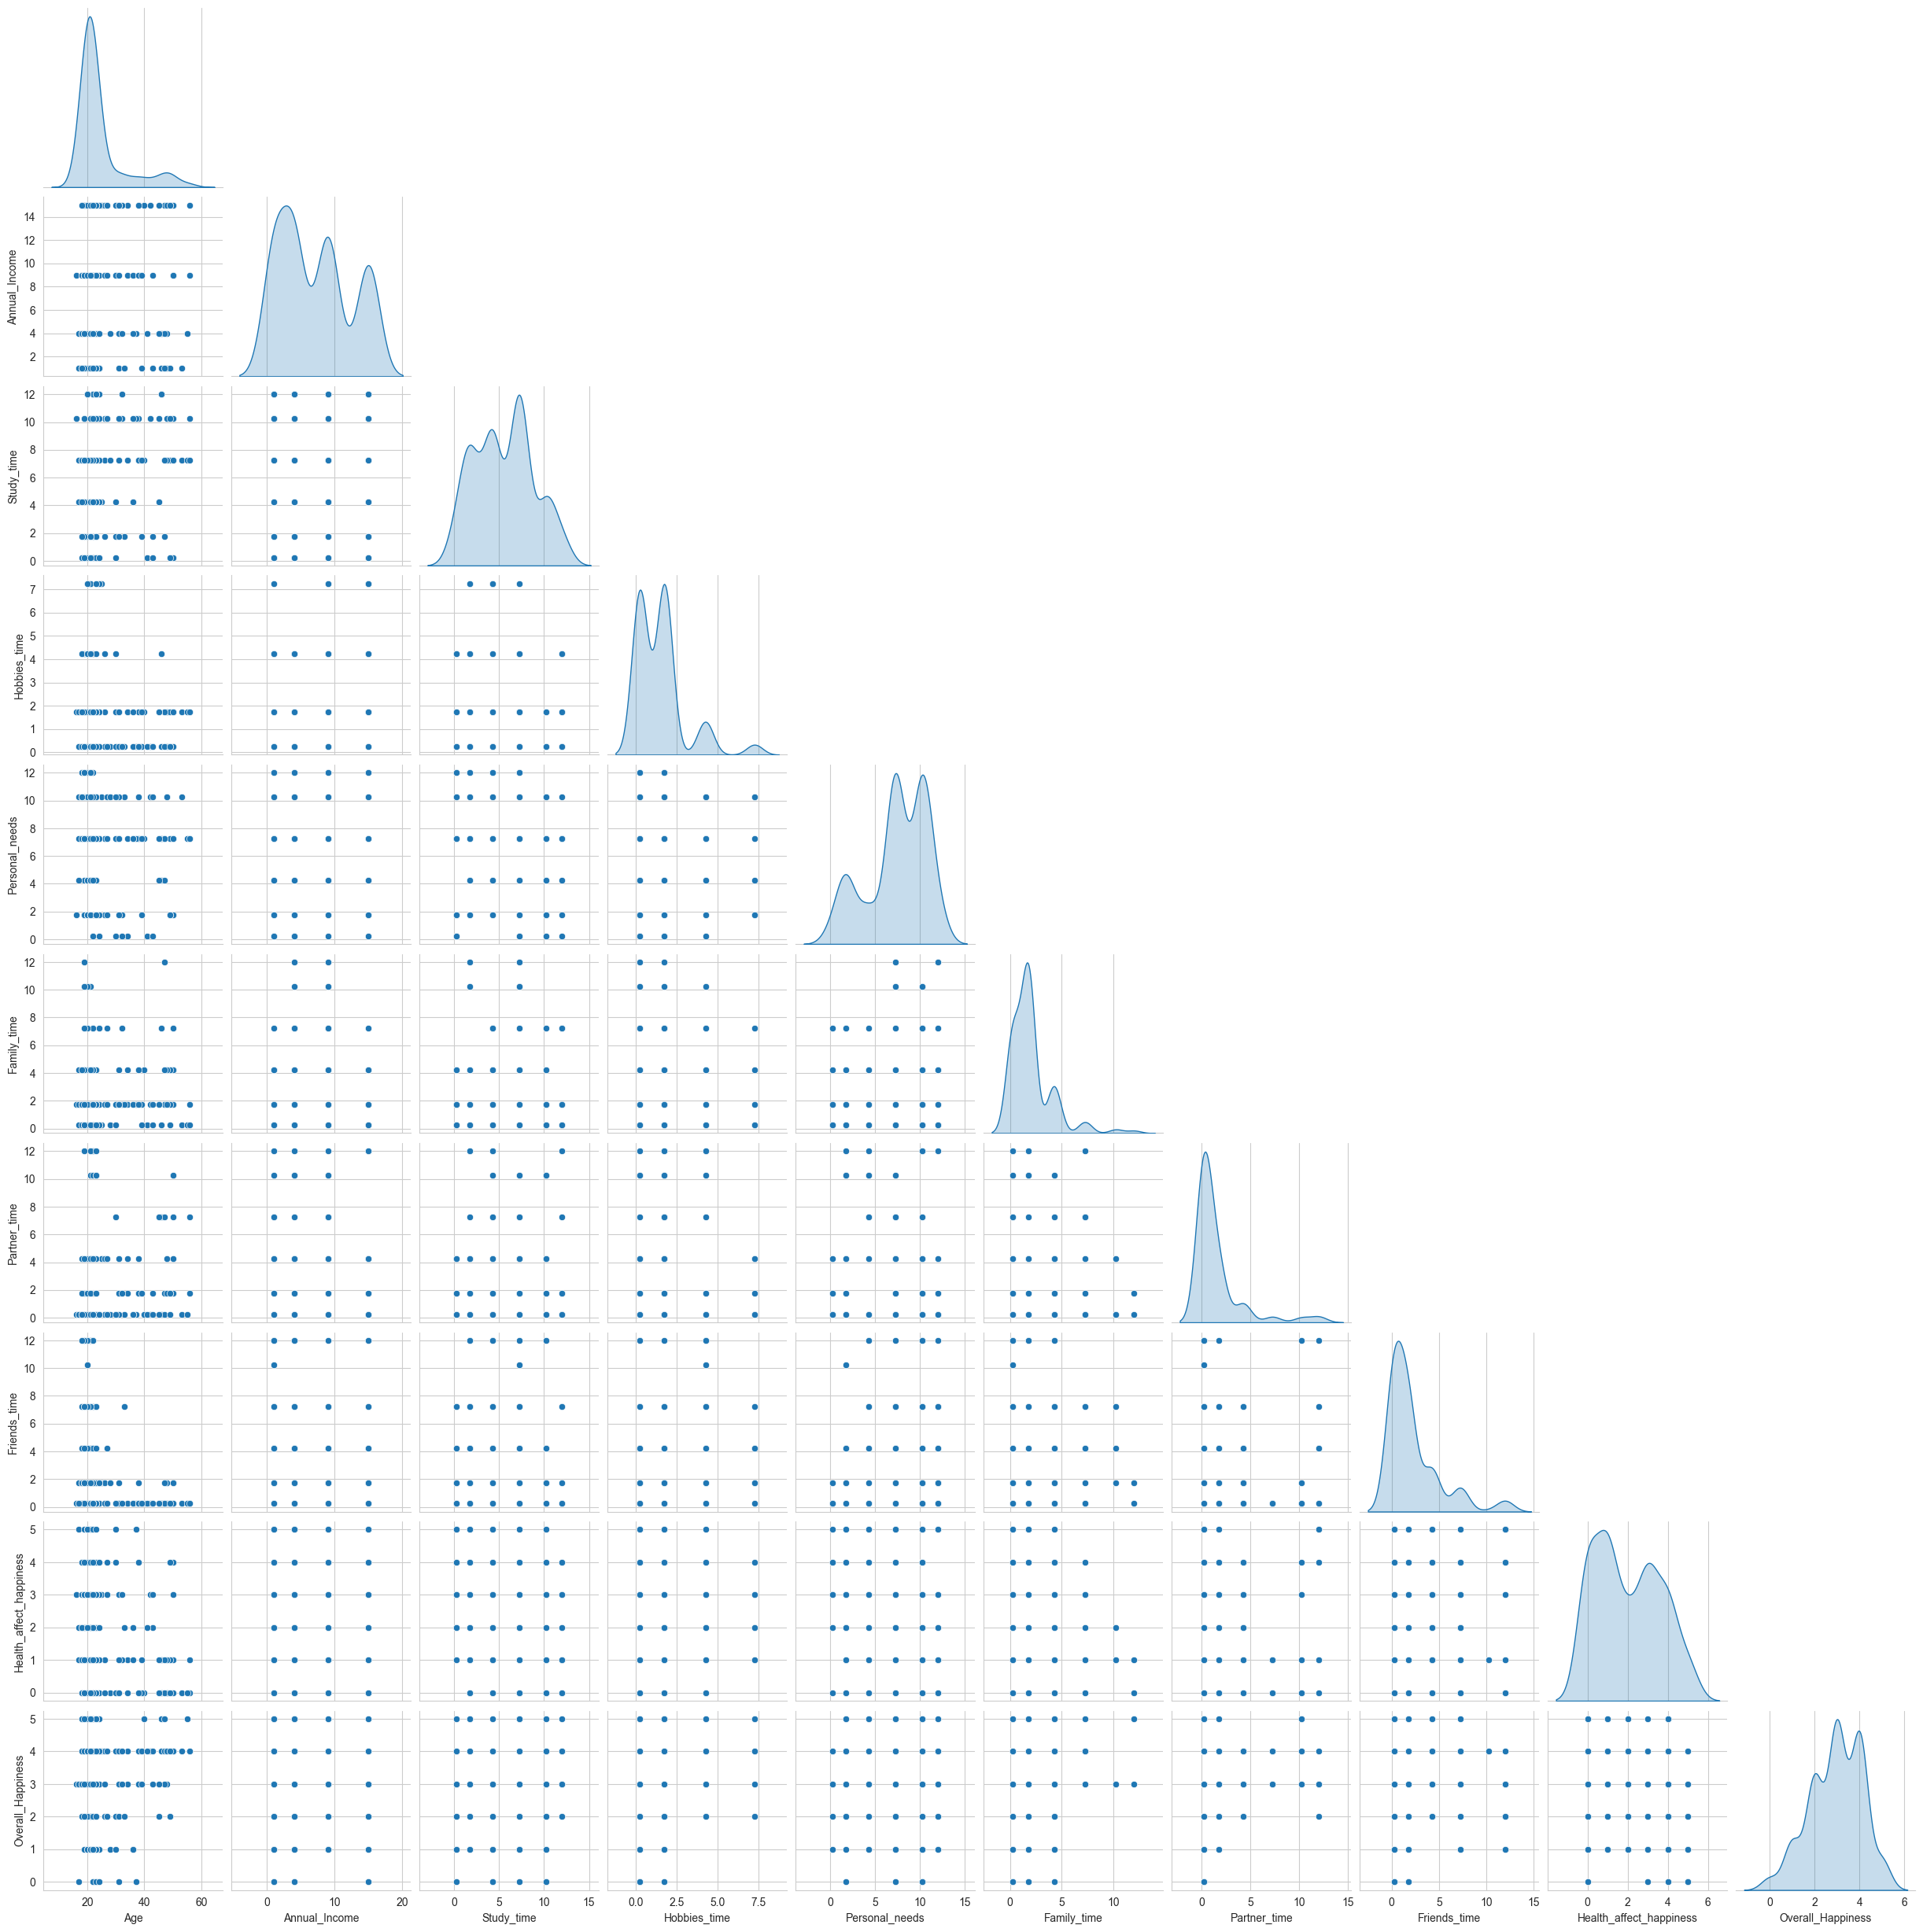

In [40]:
sns.pairplot(df[numeric_cols], diag_kind="kde", corner=True)
plt.show()


These are bar plots with error bars used to compare the average overall happiness across different categorical groups (such as gender, residence type, student/employment status, and living with family). The height of each bar represents the mean happiness score, while the error bars indicate the variability (e.g., standard deviation or confidence interval) within each group.

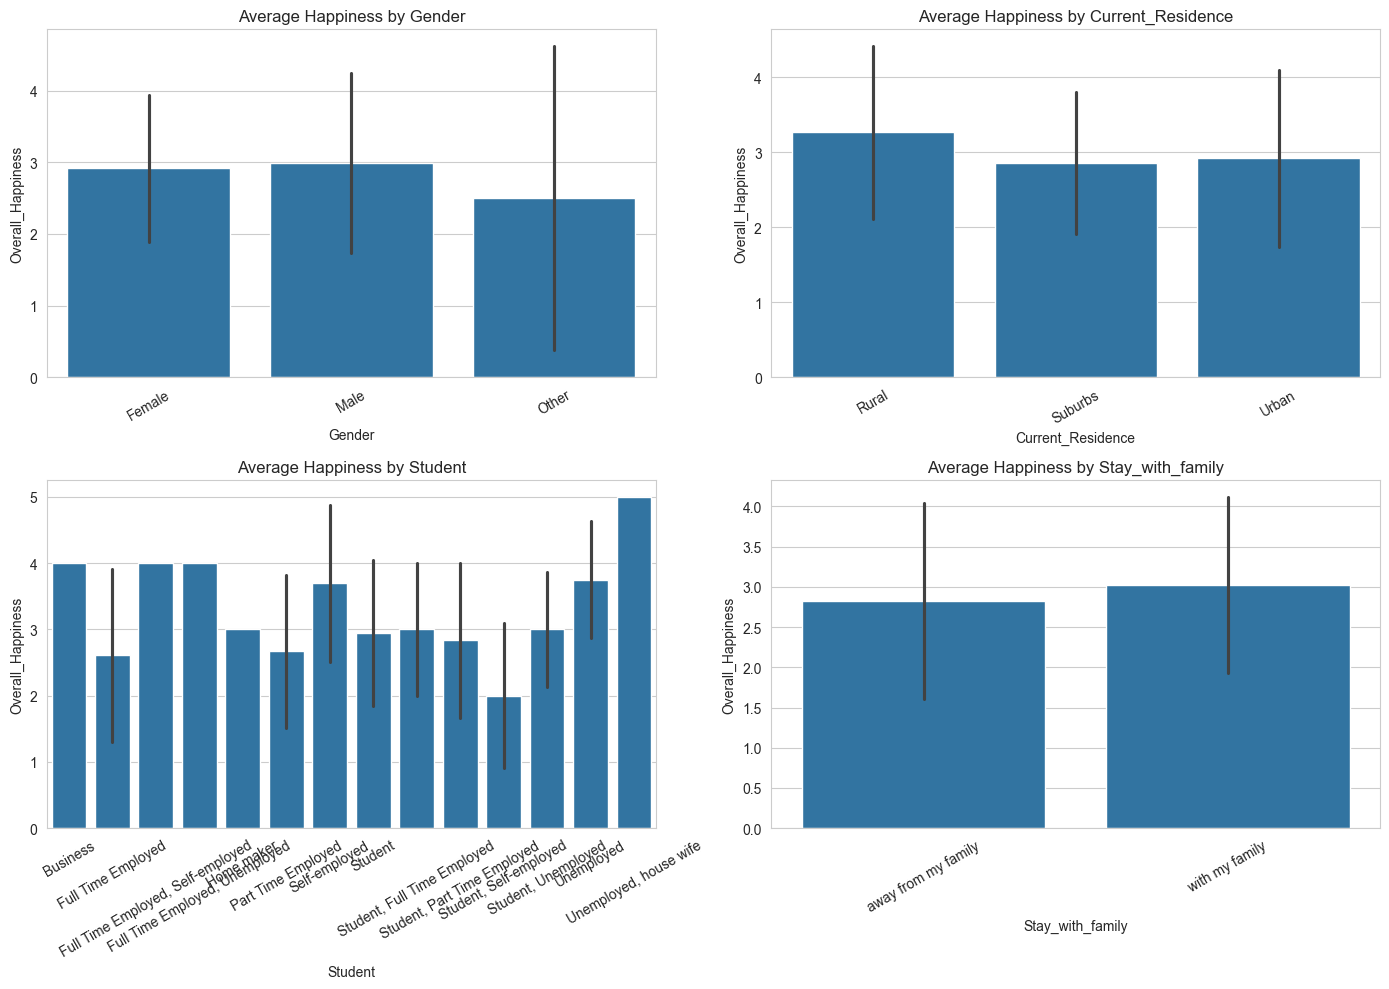

In [41]:
# Define categorical columns manually
cat_cols = ["Gender", "Current_Residence", "Student", "Stay_with_family"]

# Convert to categorical dtype
for col in cat_cols:
    df[col] = df[col].astype("category")

# Plot
plt.figure(figsize=(14,10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 2, i)
    sns.barplot(data=df, x=col, y="Overall_Happiness", errorbar='sd')
    plt.xticks(rotation=30)
    plt.title(f"Average Happiness by {col}")

plt.tight_layout()
plt.show()


This step represents feature engineering, where new variables were created from existing data to better capture meaningful patterns. These derived features include time aggregates, ratios, categorical levels, and binary indicators (e.g., work–life balance, income level, happiness and health flags), which help improve interpretability and enhance the performance of subsequent statistical and machine learning analyses.

In [42]:
import pandas as pd
import numpy as np

# -----------------------------------------------------------
# 1. Basic aggregate time features
# -----------------------------------------------------------
time_cols = [
    "Study_time", "Hobbies_time", "Personal_needs",
    "Family_time", "Partner_time", "Friends_time"
]

# Replace NaN with 0 for aggregates (safer)
df[time_cols] = df[time_cols].fillna(0)

# Total time spent across all tracked activities
df["Total_time"] = df[time_cols].sum(axis=1)

# Social interaction time: family + partner + friends
df["Social_time"] = df["Family_time"] + df["Partner_time"] + df["Friends_time"]

# "Me time": hobbies + personal needs
df["Me_time"] = df["Hobbies_time"] + df["Personal_needs"]

# Productive time (that's study time)
df["Productive_time"] = df["Study_time"]

# -----------------------------------------------------------
# 2. Ratios / balance features
# -----------------------------------------------------------
# Avoid division by zero
df["Total_time_safe"] = df["Total_time"].replace(0, np.nan)

df["Study_ratio"]  = df["Study_time"] / df["Total_time_safe"]
df["Social_ratio"] = df["Social_time"] / df["Total_time_safe"]
df["Me_ratio"]     = df["Me_time"] / df["Total_time_safe"]

# Work–life balance score
df["Work_life_balance"] = (df["Social_time"] + df["Me_time"]) - df["Study_time"]

# Drop helper column
df.drop(columns=["Total_time_safe"], inplace=True)

# -----------------------------------------------------------
# 3. Income-related features
# -----------------------------------------------------------
# Income level categories (Lakhs)
df["Income_level"] = pd.cut(
    df["Annual_Income"],
    bins=[-np.inf, 2, 6, 12, np.inf],
    labels=["Low", "Lower_Middle", "Upper_Middle", "High"]
)

# High income (>= 9 Lakhs)
df["High_income_flag"] = (df["Annual_Income"] >= 9).astype(int)

# -----------------------------------------------------------
# 4. Happiness & health derived features
# -----------------------------------------------------------
# Happiness categories
df["Happiness_level"] = pd.cut(
    df["Overall_Happiness"],
    bins=[-1, 1, 3, 5],
    labels=["Low", "Medium", "High"]
)

# Binary happiness
df["Is_happy"] = (df["Overall_Happiness"] >= 3).astype(int)

# Health effect categories
df["Health_issue_level"] = pd.cut(
    df["Health_affect_happiness"],
    bins=[-1, 1, 3, 5],
    labels=["Low", "Medium", "High"]
)

# Good health → health doesn’t affect happiness
df["Good_health_flag"] = (df["Health_affect_happiness"] <= 1).astype(int)

# -----------------------------------------------------------
# 5. Interaction / stress-style features
# -----------------------------------------------------------
# Does social time counterbalance health issues?
df["Social_vs_health"] = df["Social_time"] - df["Health_affect_happiness"]

# Overload score (positive = overworked)
df["Overload_score"] = df["Study_time"] - (df["Social_time"] + df["Me_time"])

# -----------------------------------------------------------
# 6. Check new features
# -----------------------------------------------------------
new_cols = [
    "Total_time", "Social_time", "Me_time", "Productive_time",
    "Study_ratio", "Social_ratio", "Me_ratio", "Work_life_balance",
    "Income_level", "High_income_flag",
    "Happiness_level", "Is_happy",
    "Health_issue_level", "Good_health_flag",
    "Social_vs_health", "Overload_score"
]

print("\nNew feature columns created:\n", new_cols)
print("\nSample rows:\n", df[new_cols].head())



New feature columns created:
 ['Total_time', 'Social_time', 'Me_time', 'Productive_time', 'Study_ratio', 'Social_ratio', 'Me_ratio', 'Work_life_balance', 'Income_level', 'High_income_flag', 'Happiness_level', 'Is_happy', 'Health_issue_level', 'Good_health_flag', 'Social_vs_health', 'Overload_score']

Sample rows:
    Total_time  Social_time  Me_time  Productive_time  Study_ratio  \
0        28.0         6.25     17.5             4.25     0.151786   
1        27.0         6.25     10.5            10.25     0.379630   
2        18.5         3.75     10.5             4.25     0.229730   
3        31.0        13.25     10.5             7.25     0.233871   
4        22.5         6.25     12.0             4.25     0.188889   

   Social_ratio  Me_ratio  Work_life_balance  Income_level  High_income_flag  \
0      0.223214  0.625000               19.5          High                 1   
1      0.231481  0.388889                6.5  Lower_Middle                 0   
2      0.202703  0.567568   

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# ------------------------------------------------------------
# 1. Select target and features
# ------------------------------------------------------------
target = "Is_happy"   # change if needed
X = df.drop(columns=[target])
y = df[target]

# Identify types
cat_cols = X.select_dtypes(include=["object", "category"]).columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

# ------------------------------------------------------------
# 2. Preprocessing pipeline
# ------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# ------------------------------------------------------------
# 3. Build model pipeline
# ------------------------------------------------------------
clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=1,
        random_state=42,
        class_weight="balanced"
    ))
])

# ------------------------------------------------------------
# 4. Train-test split
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.45, random_state=42, stratify=y
)

# ------------------------------------------------------------
# 5. Train model
# ------------------------------------------------------------
clf.fit(X_train, y_train)

# -------------------------------------------7-----------------
# 6. Predictions & Evaluation
# ------------------------------------------------------------
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("🎯 RANDOM FOREST CLASSIFIER RESULTS")
print("-----------------------------------")
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {prec:.4f}")
print(f"Recall     : {rec:.4f}")
print(f"F1 Score   : {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)


🎯 RANDOM FOREST CLASSIFIER RESULTS
-----------------------------------
Accuracy   : 0.9576
Precision  : 0.9868
Recall     : 0.9494
F1 Score   : 0.9677

Confusion Matrix:
[[38  1]
 [ 4 75]]


The above output shows the performance of the Random Forest Classifier used in the study. The model achieved high accuracy (95.76%), indicating strong overall predictive ability. Precision, recall, and F1-score further confirm that the model effectively balances correct positive predictions and error minimization. The confusion matrix summarizes the number of correctly and incorrectly classified observations, providing a detailed view of model performance across classes.

In [44]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\avisw\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.



 SHAP values help us understand both the direction and the strength of impact for every feature.

Each row represents one feature, and each dot represents one data point. The colour indicates whether the feature value is high or low — pink represents high values and blue represents low values. The position along the x-axis shows whether the feature is pushing the prediction toward higher happiness or lower happiness.

The first thing we notice is that ‘Overall Happiness’ is the most influential feature. When this value is high, shown by the pink dots on the right, the model strongly predicts the person to be in the high-happiness category. When the value is low, the blue dots shift towards the left, pushing the prediction toward lower happiness.

Next, the categorical happiness levels — especially ‘Happiness Level High’ and ‘Happiness Level Low’ — also have a strong influence. If someone has reported a high level of happiness, the model strongly moves its prediction toward the high category, and the opposite happens when the value is low.

We also see that family time and social–health balance are major contributors. High family time and a better social–health balance push the prediction toward higher happiness, while low values pull it toward lower happiness.

Features in the middle section, like social time, overload, work-life balance, and health affecting happiness, have a moderate but consistent impact. For example, high overload scores tend to push the prediction toward lower happiness.

Finally, the features at the bottom, such as age, me-time, and productive time, have very small SHAP values. This means they don’t influence the model’s predictions significantly compared to the other features.

Overall, the SHAP plot helps us clearly understand which factors are most important in predicting happiness and how each value contributes to the final output of the model.


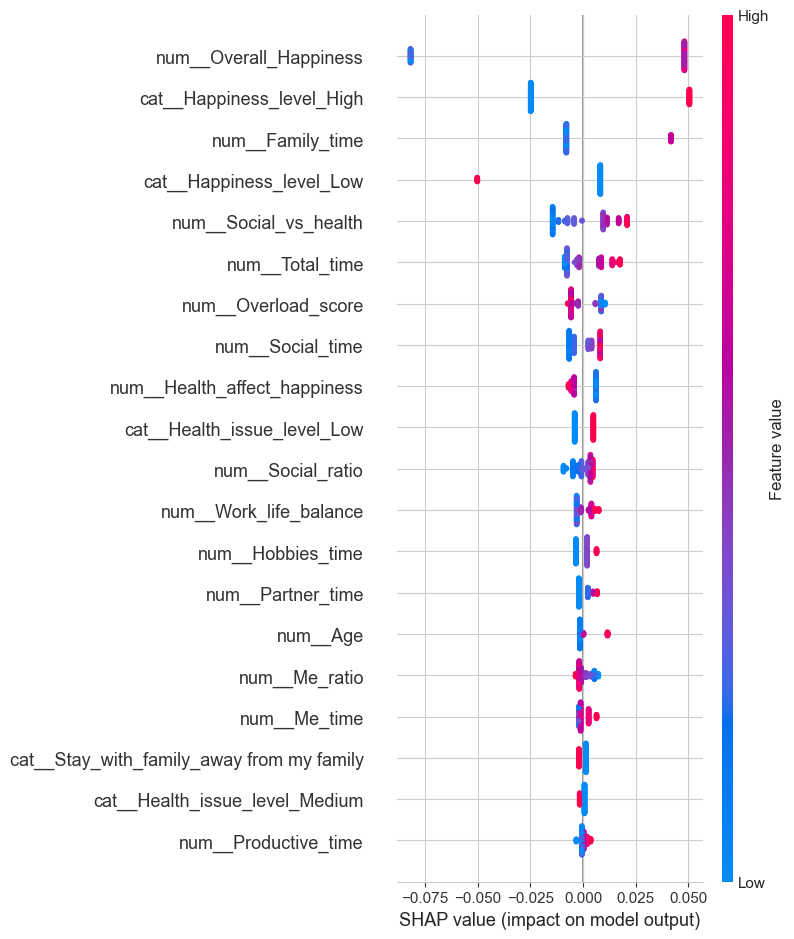

In [45]:
import shap
import numpy as np

# -----------------------------------------------------------
# 1. Extract model + preprocessing from your classifier pipeline
# -----------------------------------------------------------
rf_model = clf.named_steps["model"]
prep = clf.named_steps["preprocess"]

# -----------------------------------------------------------
# 2. Transform with the preprocessing pipeline
# -----------------------------------------------------------
X_train_transformed = prep.transform(X_train)

# Convert sparse → dense if needed
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()

# -----------------------------------------------------------
# 3. New SHAP API (recommended) - automatically picks TreeExplainer
# -----------------------------------------------------------
explainer = shap.Explainer(rf_model, X_train_transformed)

# SHAP values (for classification → 3D array)
shap_values = explainer(X_train_transformed)

# -----------------------------------------------------------
# 4. Feature names (after encoding)
# -----------------------------------------------------------
feature_names = prep.get_feature_names_out()

# -----------------------------------------------------------
# 5. Summary plot for class 1 (positive class)
# -----------------------------------------------------------
shap.summary_plot(
    shap_values[..., 1],      # class 1 contributions
    X_train_transformed,
    feature_names=feature_names
)


This is a SHAP (SHapley Additive exPlanations) summary plot that shows the relative importance and impact of features on the model’s predictions. Each point represents an observation, where the position on the x-axis (SHAP value) indicates how much a feature increases or decreases the predicted outcome, and the color represents the feature value (low to high). Features are ordered by their overall influence on the model, making the plot useful for interpreting and explaining the Random Forest model’s decisions.

Clustering:
Clustering is an unsupervised learning technique that groups data points into clusters such that observations within the same cluster are more similar to each other than to those in different clusters, helping to discover hidden patterns or structures in the data.

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select numeric columns only
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = [c for c in num_cols if c != "Overall_Happiness"]  # remove target

scaler = StandardScaler()
scaled = scaler.fit_transform(df[num_cols])

# Try KMeans with elbow idea (k=3 is usually good for happiness data)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled)

df['Cluster'] = df['Cluster'].astype('category')


C:\Users\avisw\AppData\Local\Temp\ipykernel_17488\4290717245.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Cluster', palette='Set2')


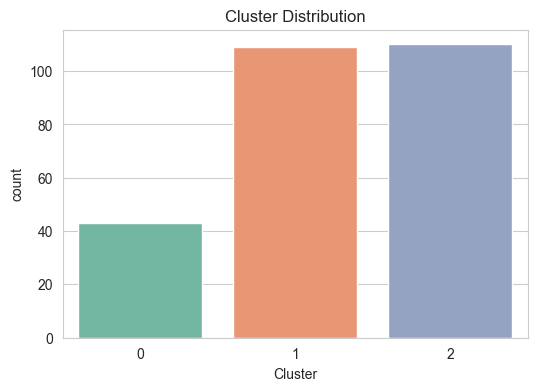

In [47]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Cluster', palette='Set2')
plt.title("Cluster Distribution")
plt.show()


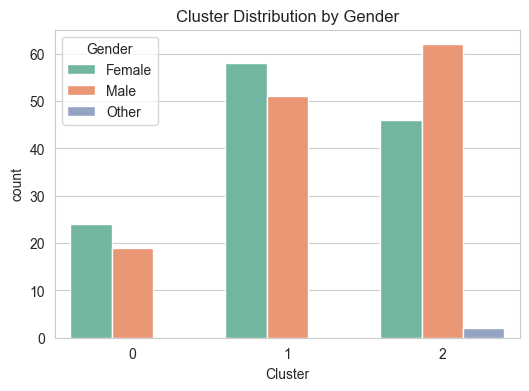

In [48]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Cluster', hue='Gender', palette='Set2')
plt.title("Cluster Distribution by Gender")
plt.show()


C:\Users\avisw\AppData\Local\Temp\ipykernel_17488\2920475106.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Cluster', y='Overall_Happiness', palette='Set2')


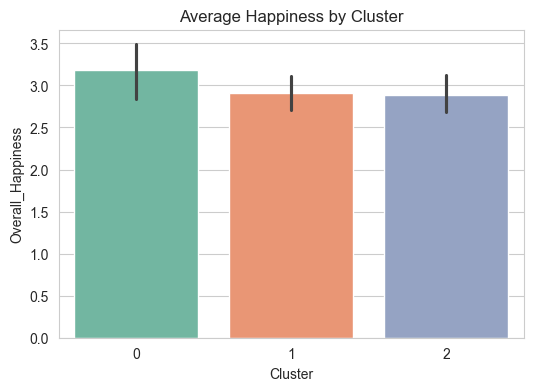

In [49]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='Cluster', y='Overall_Happiness', palette='Set2')
plt.title("Average Happiness by Cluster")
plt.show()


In [50]:
cluster_summary = df.groupby('Cluster')[num_cols + ['Overall_Happiness']].mean()
cluster_summary


C:\Users\avisw\AppData\Local\Temp\ipykernel_17488\195759637.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_summary = df.groupby('Cluster')[num_cols + ['Overall_Happiness']].mean()


,Age,Annual_Income,Study_time,Hobbies_time,Personal_needs,Family_time,Partner_time,Friends_time,Health_affect_happiness,Total_time,Social_time,Me_time,Productive_time,Study_ratio,Social_ratio,Me_ratio,Work_life_balance,Social_vs_health,Overload_score,Overall_Happiness
Cluster,,,,,,,,,,,,,,,,,,,,
0,29.069767,5.976744,4.354651,1.447674,2.784884,3.023256,3.343023,2.424419,2.232558,17.377907,8.790698,4.232558,4.354651,0.235397,0.497744,0.266859,8.668605,6.558140,-8.668605,3.186047
1,22.137615,6.669725,3.596330,1.814220,9.747706,2.224771,1.552752,3.449541,2.211009,22.385321,7.227064,11.561927,3.596330,0.154572,0.298746,0.546682,15.192661,5.016055,-15.192661,2.908257
2,25.381818,7.936364,7.975000,1.122727,6.904545,1.436364,0.677273,0.959091,1.709091,19.075000,3.072727,8.027273,7.975000,0.424788,0.159438,0.415775,3.125000,1.363636,-3.125000,2.890909
